# Binance Client Test Notebook

In [1]:
import sys
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import threading
import time

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from clients.binance_client import BinanceClient

/Users/cleme/stablecoins_optimizer/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Initialize Binance Client

In [2]:
# Initialize client
client = BinanceClient(api_key=os.getenv('binance_api_key'), api_secret=os.getenv('binance_api_secret'), leverage=2, verbose=True)


## Fetch Current Funding Rates

In [6]:
symbols = ['BTC/USDT:USDT', 
           'ETH/USDT:USDT', 
           'SOL/USDT:USDT', 
           'XRP/USDT:USDT', 
           'BNB/USDT:USDT', 
           'DOGE/USDT:USDT', 
           '1000PEPE/USDT:USDT', 
           'TON/USDT:USDT', 
           'AVAX/USDT:USDT', 
           'WIF/USDT:USDT', 
           'MATIC/USDT:USDT', 
           'AAVE/USDT:USDT', 
           'LINK/USDT:USDT', 
           'SUI/USDT:USDT', 
           'ADA/USDT:USDT']
current_rates = client.get_current_funding_rates(symbols)
print("Current Funding Rates:")
display(current_rates)

Current Funding Rates:


,Symbol,Mark Price,Index Price,Funding Rate,Timestamp,Datetime,Funding Timestamp,Funding Datetime,Annualized Funding Rate
0,BTC/USDT:USDT,63909.200000,63931.910851,0.000032,1724590875000,2024-08-25T13:01:15.000Z,1724601600000,2024-08-25T16:00:00.000Z,3.533565
1,ETH/USDT:USDT,2750.930000,2752.279545,0.000052,1724590875000,2024-08-25T13:01:15.000Z,1724601600000,2024-08-25T16:00:00.000Z,5.723565
2,SOL/USDT:USDT,157.758000,157.836278,0.000100,1724590876000,2024-08-25T13:01:16.000Z,1724601600000,2024-08-25T16:00:00.000Z,10.904010
3,XRP/USDT:USDT,0.602600,0.602745,-0.000008,1724590876000,2024-08-25T13:01:16.000Z,1724601600000,2024-08-25T16:00:00.000Z,-0.849720
4,BNB/USDT:USDT,574.860000,575.093186,-0.000064,1724590876000,2024-08-25T13:01:16.000Z,1724601600000,2024-08-25T16:00:00.000Z,-7.023330
5,DOGE/USDT:USDT,0.109119,0.109119,0.000079,1724590876000,2024-08-25T13:01:16.000Z,1724601600000,2024-08-25T16:00:00.000Z,8.705250
6,1000PEPE/USDT:USDT,0.009073,0.009078,0.000100,1724590877000,2024-08-25T13:01:17.000Z,1724601600000,2024-08-25T16:00:00.000Z,10.950000
7,TON/USDT:USDT,5.671787,5.674933,0.000050,1724590877000,2024-08-25T13:01:17.000Z,1724601600000,2024-08-25T16:00:00.000Z,5.475000
8,AVAX/USDT:USDT,26.595000,26.608534,0.000065,1724590878001,2024-08-25T13:01:18.001Z,1724601600000,2024-08-25T16:00:00.000Z,7.069320
9,WIF/USDT:USDT,1.910818,1.911953,0.000050,1724590878001,2024-08-25T13:01:18.001Z,1724601600000,2024-08-25T16:00:00.000Z,5.475000


## Visualize Current Funding Rates

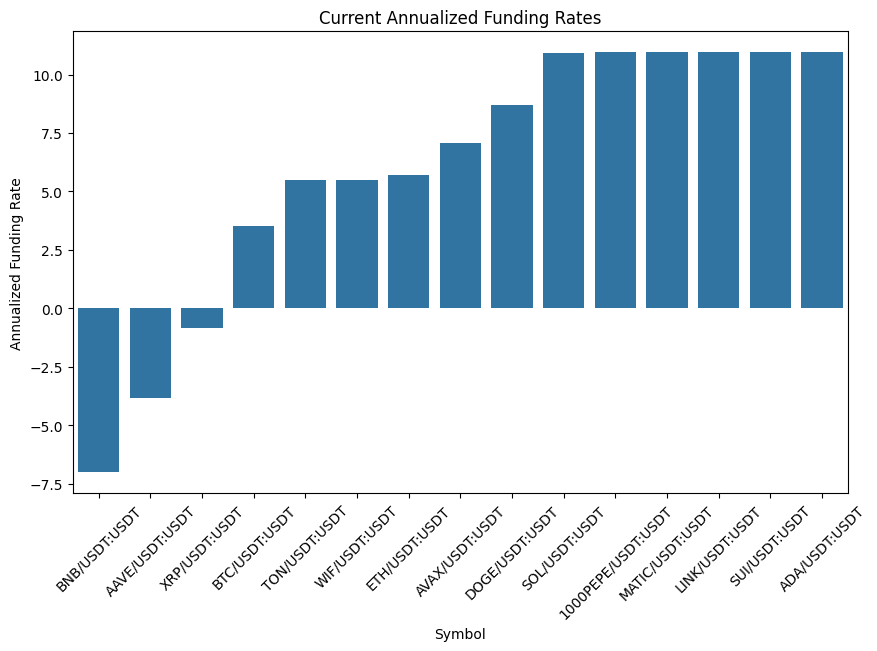

In [7]:
plt.figure(figsize=(10, 6))
current_rates_sorted = current_rates.sort_values(by='Annualized Funding Rate')
sns.barplot(x='Symbol', y='Annualized Funding Rate', data=current_rates_sorted)
plt.title('Current Annualized Funding Rates')
plt.xticks(rotation=45)
plt.show()

## Fetch current positions and prices on Future and Spot

In [8]:
# Symbol for basis trade
symbol = 'LINK/USDT'

# Fetch spot position (last 24 hours by default)
spot_position = client.fetch_spot_position(symbol)
print("Spot Position (last 24 hours):")
display(pd.DataFrame([spot_position]))

# If you want to change the time window, you can do so like this:
# spot_position_48h = client.fetch_spot_position(symbol, time_window=48)
# print("Spot Position (last 48 hours):")
# display(pd.DataFrame([spot_position_48h]))

Spot Position (last 24 hours):


,symbol,amount,entry_price,current_price,pnl,pnl_percentage,value_base,value_quote,last_trade_amount,last_trade_side,last_trade_time
0,LINK/USDT,0.0033,None,12.15,None,None,0.0033,0.040095,0,None,None


In [6]:
# Fetch futures position
futures_position = client.fetch_futures_position(symbol)
print("Futures Position:")
display(pd.DataFrame([futures_position]))

Futures Position:


,0
0,None


In [20]:
# Calculate basis (sell fut, buy spot)
if spot_position and futures_position:
    basis = futures_position['current_price'] - spot_position['current_price']
    basis_percentage = (basis / spot_position['current_price']) * 100
    print(f"Current Basis: {basis:.2f} USDT ({basis_percentage:.2f}%)")


Current Basis: -0.01 USDT (-0.05%)


In [21]:
# Fetch current funding rate
funding_rates = client.get_current_funding_rates([symbol])
print("Current Funding Rate:")
display(funding_rates)

Current Funding Rate:


,Symbol,Mark Price,Index Price,Funding Rate,Timestamp,Datetime,Funding Timestamp,Funding Datetime,Annualized Funding Rate
0,LINK/USDT:USDT,11.974,11.976056,0.000087,1724481567000,2024-08-24T06:39:27.000Z,1724486400000,2024-08-24T08:00:00.000Z,9.562635


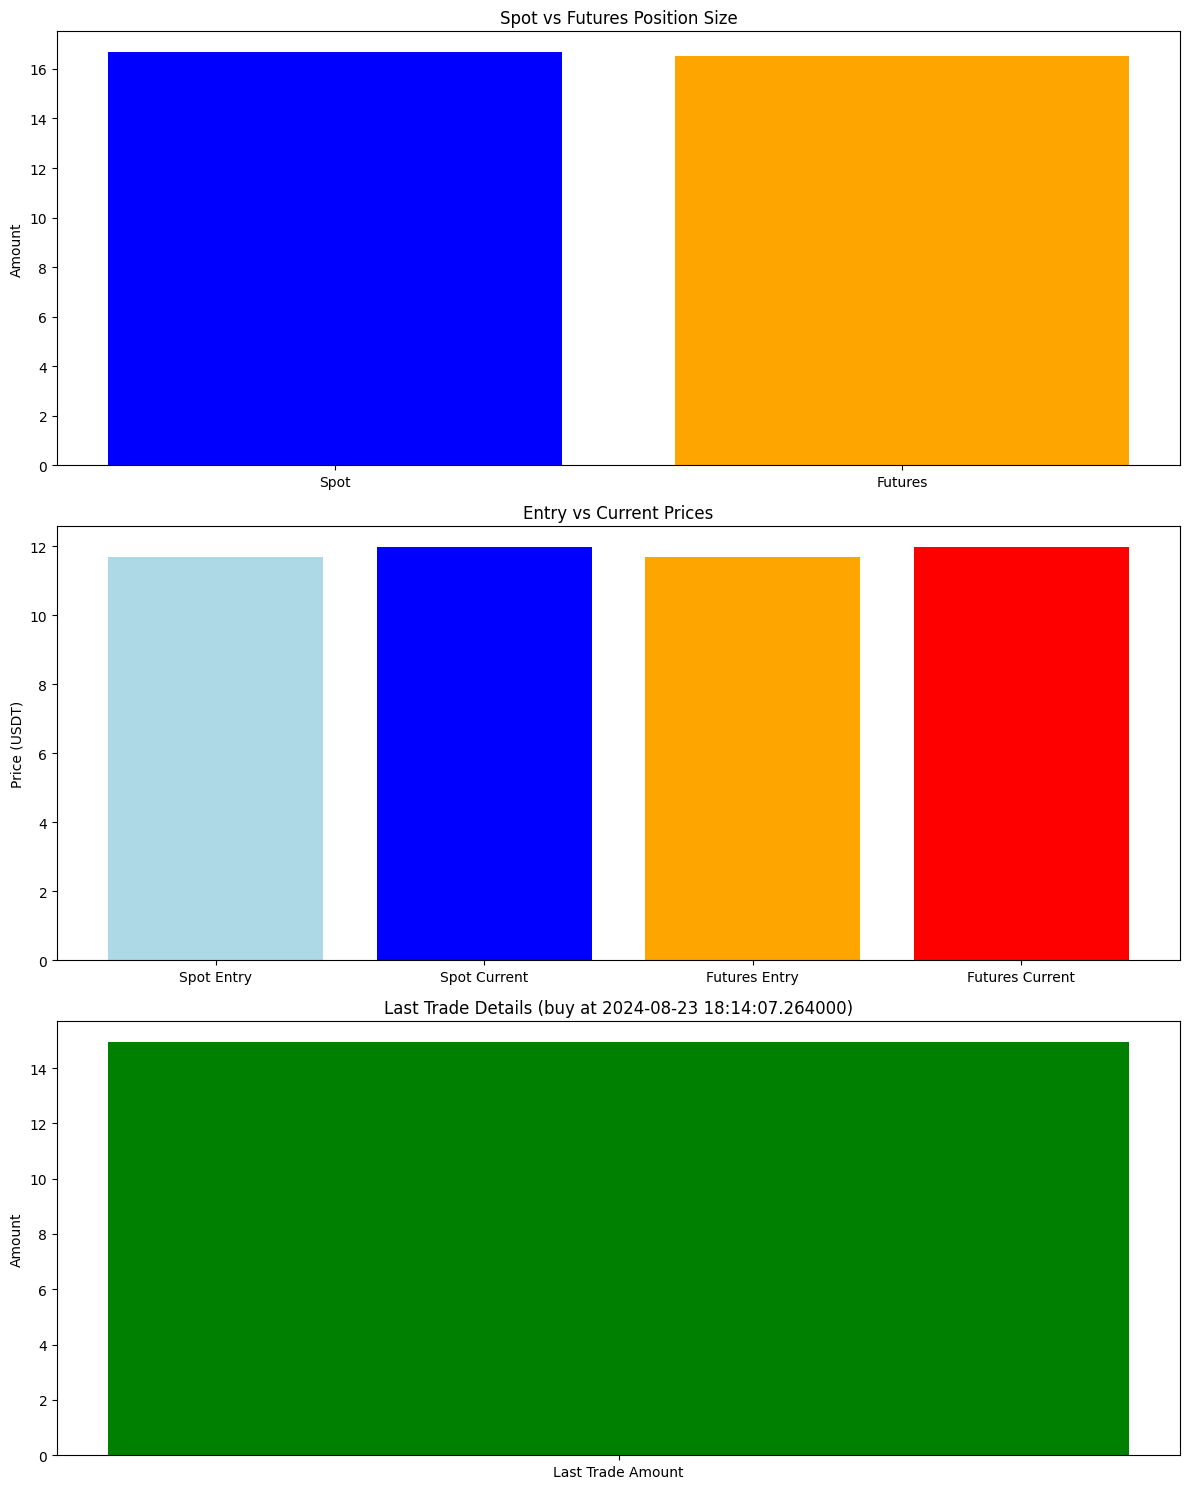

In [22]:
# Visualize the basis trade
if spot_position and futures_position:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    
    # Plot positions
    ax1.bar(['Spot', 'Futures'], [spot_position['amount'], futures_position['amount']], color=['blue', 'orange'])
    ax1.set_title('Spot vs Futures Position Size')
    ax1.set_ylabel('Amount')
    
    # Plot prices
    ax2.bar(['Spot Entry', 'Spot Current', 'Futures Entry', 'Futures Current'], 
            [spot_position['entry_price'], spot_position['current_price'], 
             futures_position['entry_price'], futures_position['current_price']],
            color=['lightblue', 'blue', 'orange', 'red'])
    ax2.set_title('Entry vs Current Prices')
    ax2.set_ylabel('Price (USDT)')
    
    # Plot last trade details
    ax3.bar(['Last Trade Amount'], [spot_position['last_trade_amount']], color='green')
    ax3.set_title(f"Last Trade Details ({spot_position['last_trade_side']} at {spot_position['last_trade_time']})")
    ax3.set_ylabel('Amount')
    
    plt.tight_layout()
    plt.show()

## Backtest basis trade

In [3]:
symbol = 'REEF/USDT'

# Get the last 1000 minutes of basis spread data
basis_spread_df = client.calculate_basis_spread(symbol)
basis_spread_df.to_csv('basis_spread.csv', index=False)

# Print the last 10 rows
print(basis_spread_df.tail(10))

# Calculate average basis spread
#average_spread = basis_spread_df['basis_spread_percentage'].mean()
#print(f"Average basis spread over the last 1000 minutes: {average_spread:.4f}%")

         timestamp  open_spot  high_spot  low_spot  close_spot  volume_spot  \
990  1724518740000   0.000821   0.000821  0.000820    0.000820     127356.0   
991  1724518800000   0.000820   0.000822  0.000819    0.000822    2559259.0   
992  1724518860000   0.000821   0.000823  0.000821    0.000821    3606758.0   
993  1724518920000   0.000821   0.000823  0.000821    0.000823    1334991.0   
994  1724518980000   0.000823   0.000823  0.000822    0.000822     127942.0   
995  1724519040000   0.000822   0.000823  0.000822    0.000823     524910.0   
996  1724519100000   0.000822   0.000823  0.000821    0.000822     136442.0   
997  1724519160000   0.000822   0.000822  0.000822    0.000822     105517.0   
998  1724519220000   0.000822   0.000822  0.000822    0.000822      18226.0   
999  1724519280000   0.000823   0.000823  0.000822    0.000822     181882.0   

          datetime_spot  open_futures  high_futures  low_futures  \
990 2024-08-24 16:59:00      0.000822      0.000823     0.0008

In [4]:
symbols_to_monitor = ['REEFUSDT', '1000SATSUSDT', 'SUIUSDT', 'BAKEUSDT', 'ADAUSDT']

# Start WebSocket streams
client.start_websocket_streams(symbols_to_monitor)

# Start monitoring basis spreads with custom settings
threading.Thread(target=client.monitor_basis_spreads, args=(symbols_to_monitor, 0.004, -0.0005, 5, 300, False)).start()

# Keep the main thread running
while True:
    time.sleep(1)

Search in progress...

INFO:websocket:Websocket connected
INFO:websocket:Websocket connected


Still searching......
Current spreads at 2024-08-24 20:04:29:
REEFUSDT: 0.1894%
1000SATSUSDT: -0.1325%
SUIUSDT: -0.0588%
BAKEUSDT: -0.0322%
ADAUSDT: -0.0505%

Search in progress...
Current spreads at 2024-08-24 20:09:30:
REEFUSDT: 0.2414%
1000SATSUSDT: 0.0075%
SUIUSDT: -0.0129%
BAKEUSDT: -0.0060%
ADAUSDT: -0.0503%

Still searching......
Current spreads at 2024-08-24 20:14:30:
REEFUSDT: 0.1667%
1000SATSUSDT: -0.0598%
SUIUSDT: -0.0491%
BAKEUSDT: -0.0284%
ADAUSDT: -0.0502%

Search in progress...
Current spreads at 2024-08-24 20:19:31:
REEFUSDT: 0.2503%
1000SATSUSDT: -0.0248%
SUIUSDT: -0.0191%
BAKEUSDT: -0.0044%
ADAUSDT: -0.0251%

Still searching......
Current spreads at 2024-08-24 20:24:31:
REEFUSDT: 0.2439%
1000SATSUSDT: 0.0074%
SUIUSDT: 0.0386%
BAKEUSDT: -0.0990%
ADAUSDT: -0.0491%

Search in progress...
Current spreads at 2024-08-24 20:29:32:
REEFUSDT: 0.2149%
1000SATSUSDT: -0.0198%
SUIUSDT: -0.0291%
BAKEUSDT: -0.0814%
ADAUSDT: -0.0185%

Still searching......
Current spreads at 2024-08-

KeyboardInterrupt: 

Still searching......
Current spreads at 2024-08-25 07:55:46:
REEFUSDT: 0.1294%
1000SATSUSDT: -0.0398%
SUIUSDT: -0.0101%
BAKEUSDT: 0.0000%
ADAUSDT: -0.0259%

Search in progress...
Current spreads at 2024-08-25 08:00:46:
REEFUSDT: 0.1290%
1000SATSUSDT: -0.0124%
SUIUSDT: -0.0101%
BAKEUSDT: -0.0368%
ADAUSDT: -0.0413%

Still searching......
Current spreads at 2024-08-25 08:05:46:
REEFUSDT: 0.1770%
1000SATSUSDT: -0.0150%
SUIUSDT: -0.0604%
BAKEUSDT: -0.0210%
ADAUSDT: -0.0259%

Still searching......
Current spreads at 2024-08-25 08:10:50:
REEFUSDT: 0.1705%
1000SATSUSDT: -0.0324%
SUIUSDT: -0.0201%
BAKEUSDT: -0.0216%
ADAUSDT: -0.0513%

Still searching......
Current spreads at 2024-08-25 08:15:58:
REEFUSDT: 0.1705%
1000SATSUSDT: -0.0324%
SUIUSDT: -0.0201%
BAKEUSDT: -0.0216%
ADAUSDT: -0.0513%

Still searching......
Current spreads at 2024-08-25 08:21:26:
REEFUSDT: 0.1294%
1000SATSUSDT: -0.0125%
SUIUSDT: -0.0709%
BAKEUSDT: -0.0620%
ADAUSDT: -0.0400%

Search in progress...
Current spreads at 2024-0

## Live trade basis trade

In [ ]:
#symbols_to_monitor = ['REEFUSDT', '1000SATSUSDT', 'BAKEUSDT', 'ONEUSDT']
symbols_to_monitor = ['ONEUSDT']

# Start WebSocket streams
client.start_websocket_streams(symbols_to_monitor)

# Start monitoring basis spreads
threading.Thread(target=client.monitor_basis_spreads, args=(
    symbols_to_monitor,
    0.0005,               # entry_threshold
    0.0001,              # exit_threshold
    2,                   # interval
    20,                 # update_interval
    False,               # log_all_prices
    True,                # execute_trades
    10                   # trade_amount_usd
)).start()

# Keep the main thread running
try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("Stopping the monitor...")
finally:
    # Stop WebSocket streams
    client.stop_websocket_streams()

2024-08-26 10:26:46,070 - INFO - Starting to monitor basis spreads for ['ONEUSDT']
2024-08-26 10:26:46,070 - INFO - Settings: entry_threshold=0.0005, exit_threshold=0.0001, interval=2, update_interval=20, log_all_prices=False, execute_trades=True, trade_amount_usd=10
2024-08-26 10:26:46,071 - WARNING - Latest prices not available for ONEUSDT. Fetching from API.



fetch Request: binance GET https://api.binance.com/api/v3/ticker/24hr?symbol=ONEUSDT RequestHeaders: {'User-Agent': 'python-requests/2.32.3', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive'} RequestBody: None

fetch Response: binance GET https://api.binance.com/api/v3/ticker/24hr?symbol=ONEUSDT 200 ResponseHeaders: {'Content-Type': 'application/json;charset=UTF-8', 'Content-Length': '284', 'Connection': 'keep-alive', 'Date': 'Mon, 26 Aug 2024 08:26:46 GMT', 'Access-Control-Allow-Methods': 'GET, HEAD, OPTIONS', 'Server': 'nginx', 'x-mbx-uuid': '9c83c88a-0aeb-40df-97b6-7742c4b7aba2', 'x-mbx-used-weight': '42', 'x-mbx-used-weight-1m': '42', 'content-encoding': 'gzip', 'Strict-Transport-Security': 'max-age=31536000; includeSubdomains', 'X-Frame-Options': 'SAMEORIGIN', 'X-Xss-Protection': '1; mode=block', 'X-Content-Type-Options': 'nosniff', 'Content-Security-Policy': "default-src 'self'", 'X-Content-Security-Policy': "default-src 'self'", 'X-WebKit-CSP': "d

2024-08-26 10:26:46,853 - INFO - 
ENTRY POINT for ONEUSDT: Margin much higher than futures. Spread: {'margin_price': 0.01362, 'futures_price': 0.01361, 'basis_spread': -9.999999999999593e-06, 'basis_spread_percentage': -0.07342143906020258}



fetch Response: binance GET https://fapi.binance.com/fapi/v1/ticker/24hr?symbol=ONEUSDT 200 ResponseHeaders: {'Date': 'Mon, 26 Aug 2024 08:26:46 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Server': 'Tengine', 'Vary': 'Accept-Encoding', 'x-mbx-used-weight-1m': '23', 'x-response-time': '0ms', 'Access-Control-Allow-Origin': '*', 'Access-Control-Allow-Methods': 'GET, POST, PUT, DELETE, OPTIONS', 'Access-Control-Allow-Credentials': 'true', 'Access-Control-Allow-Headers': '*,clienttype,Content-Type,lang,x-ui-request-trace,bnc-uuid', 'Content-Security-Policy': "default-src 'self'", 'cache-control': 'no-cache, no-store, must-revalidate', 'expires': '0', 'pragma': 'no-cache', 'strict-transport-security': 'max-age=31536000; includeSubdomains', 'x-content-type-options': 'nosniff', 'x-frame-options': 'SAMEORIGIN', 'x-xss-protection': '1; mode=block', 'Content-Encoding': 'gzip'} ResponseBody: {"symbol":"ONEUSDT","priceChange":"0.00024","pr

2024-08-26 10:26:47,331 - INFO - API key permissions: ['SPOT']
2024-08-26 10:26:47,331 - WARNING - API key does not have margin trading permission
2024-08-26 10:26:47,332 - ERROR - Error checking margin account type: 'binance' object has no attribute 'private_get_margin_account'



fetch Response: binance GET https://api.binance.com/api/v3/account?timestamp=1724660806853&recvWindow=10000&signature=f7f55e430dddd3c6b0a5d7b415a7b633db75119e98ff2a13ea57bba716afbe81 200 ResponseHeaders: {'Content-Type': 'application/json;charset=UTF-8', 'Content-Length': '2668', 'Connection': 'keep-alive', 'Date': 'Mon, 26 Aug 2024 08:26:46 GMT', 'Access-Control-Allow-Methods': 'GET, HEAD, OPTIONS', 'Server': 'nginx', 'x-mbx-uuid': '0f8e431e-0ce2-4cb1-91a4-585f476dc0c9', 'x-mbx-used-weight': '62', 'x-mbx-used-weight-1m': '62', 'content-encoding': 'gzip', 'Strict-Transport-Security': 'max-age=31536000; includeSubdomains', 'X-Frame-Options': 'SAMEORIGIN', 'X-Xss-Protection': '1; mode=block', 'X-Content-Type-Options': 'nosniff', 'Content-Security-Policy': "default-src 'self'", 'X-Content-Security-Policy': "default-src 'self'", 'X-WebKit-CSP': "default-src 'self'", 'Cache-Control': 'no-cache, no-store, must-revalidate', 'Pragma': 'no-cache', 'Expires': '0', 'Access-Control-Allow-Origin':

2024-08-26 10:26:48,132 - INFO - Websocket connected
2024-08-26 10:26:48,328 - INFO - Websocket connected



fetch Response: binance GET https://fapi.binance.com/fapi/v1/ticker/24hr?symbol=ONEUSDT 200 ResponseHeaders: {'Date': 'Mon, 26 Aug 2024 08:26:47 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Server': 'Tengine', 'Vary': 'Accept-Encoding', 'x-mbx-used-weight-1m': '24', 'x-response-time': '0ms', 'Access-Control-Allow-Origin': '*', 'Access-Control-Allow-Methods': 'GET, POST, PUT, DELETE, OPTIONS', 'Access-Control-Allow-Credentials': 'true', 'Access-Control-Allow-Headers': '*,clienttype,Content-Type,lang,x-ui-request-trace,bnc-uuid', 'Content-Security-Policy': "default-src 'self'", 'cache-control': 'no-cache, no-store, must-revalidate', 'expires': '0', 'pragma': 'no-cache', 'strict-transport-security': 'max-age=31536000; includeSubdomains', 'x-content-type-options': 'nosniff', 'x-frame-options': 'SAMEORIGIN', 'x-xss-protection': '1; mode=block', 'Content-Encoding': 'gzip'} ResponseBody: {"symbol":"ONEUSDT","priceChange":"0.00024","pr

2024-08-26 10:26:49,224 - INFO - Attempting trade for ONEUSDT. Amount: 10 USDT
2024-08-26 10:26:49,225 - INFO - Available balance - Cross Margin: 199.4981314 USDT, Futures: 93.0674824 USDT
2024-08-26 10:26:49,226 - INFO - Calculated trade quantity: 734.4 ONE
2024-08-26 10:26:49,228 - INFO - Limit prices - Margin: 0.01361, Futures: 0.01362



fetch Response: binance GET https://fapi.binance.com/fapi/v3/account?timestamp=1724660808728&recvWindow=10000&signature=b8ab1a88f415cf5966591470195c939a50d52b59201e21eaee04c1944d1a0969 200 ResponseHeaders: {'Date': 'Mon, 26 Aug 2024 08:26:48 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Server': 'Tengine', 'Vary': 'Accept-Encoding', 'x-mbx-used-weight-1m': '29', 'x-response-time': '3ms', 'Access-Control-Allow-Origin': '*', 'Access-Control-Allow-Methods': 'GET, POST, PUT, DELETE, OPTIONS', 'Access-Control-Allow-Credentials': 'true', 'Access-Control-Allow-Headers': '*', 'Content-Security-Policy': "default-src 'self'", 'cache-control': 'no-cache, no-store, must-revalidate', 'expires': '0', 'pragma': 'no-cache', 'strict-transport-security': 'max-age=31536000; includeSubdomains', 'x-content-type-options': 'nosniff', 'x-frame-options': 'SAMEORIGIN', 'x-xss-protection': '1; mode=block', 'Content-Encoding': 'gzip'} ResponseBody: {"total

2024-08-26 10:26:49,678 - INFO - Attempting to borrow 734.4 ONE for short selling
2024-08-26 10:26:49,679 - ERROR - Error in direct margin borrow: 'binance' object has no attribute 'private_post_margin_loan'
2024-08-26 10:26:49,680 - ERROR - Failed to borrow 734.4 ONE for short selling. Skipping trade.



fetch Response: binance POST https://fapi.binance.com/fapi/v1/leverage 200 ResponseHeaders: {'Date': 'Mon, 26 Aug 2024 08:26:49 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Server': 'Tengine', 'Vary': 'Accept-Encoding', 'x-mbx-used-weight-1m': '30', 'x-response-time': '4ms', 'Access-Control-Allow-Origin': '*', 'Access-Control-Allow-Methods': 'GET, POST, PUT, DELETE, OPTIONS', 'Access-Control-Allow-Credentials': 'true', 'Access-Control-Allow-Headers': '*,clienttype,Content-Type,lang,x-ui-request-trace,bnc-uuid', 'Content-Security-Policy': "default-src 'self'", 'cache-control': 'no-cache, no-store, must-revalidate', 'expires': '0', 'pragma': 'no-cache', 'strict-transport-security': 'max-age=31536000; includeSubdomains', 'x-content-type-options': 'nosniff', 'x-frame-options': 'SAMEORIGIN', 'x-xss-protection': '1; mode=block', 'Content-Encoding': 'gzip'} ResponseBody: {"symbol":"ONEUSDT","leverage":2,"maxNotionalValue":"1000000"}


2024-08-26 10:26:51,686 - INFO - 
ENTRY POINT for ONEUSDT: Margin much higher than futures. Spread: {'margin_price': 0.01362, 'futures_price': 0.01361, 'basis_spread': -9.999999999999593e-06, 'basis_spread_percentage': -0.07342143906020258}



fetch Request: binance GET https://api.binance.com/api/v3/account?timestamp=1724660811687&recvWindow=10000&signature=4839c75f627a03cebae882ccea5c01b1f4a073677756c7af4c9e10c6f9cfa242 RequestHeaders: {'X-MBX-APIKEY': 'vz15GJe9hpmKpW3o1fthINAVVCxw7TRY31pq11KkOIXqtsDGNwuULuP8mmrqNjDf', 'User-Agent': 'python-requests/2.32.3', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive'} RequestBody: None


2024-08-26 10:26:52,291 - INFO - API key permissions: ['SPOT']
2024-08-26 10:26:52,292 - WARNING - API key does not have margin trading permission
2024-08-26 10:26:52,292 - ERROR - Error checking margin account type: 'binance' object has no attribute 'private_get_margin_account'



fetch Response: binance GET https://api.binance.com/api/v3/account?timestamp=1724660811687&recvWindow=10000&signature=4839c75f627a03cebae882ccea5c01b1f4a073677756c7af4c9e10c6f9cfa242 200 ResponseHeaders: {'Content-Type': 'application/json;charset=UTF-8', 'Content-Length': '2668', 'Connection': 'keep-alive', 'Date': 'Mon, 26 Aug 2024 08:26:51 GMT', 'Access-Control-Allow-Methods': 'GET, HEAD, OPTIONS', 'Server': 'nginx', 'x-mbx-uuid': '9007aafd-3323-4af8-9887-4ccf5f267197', 'x-mbx-used-weight': '84', 'x-mbx-used-weight-1m': '84', 'content-encoding': 'gzip', 'Strict-Transport-Security': 'max-age=31536000; includeSubdomains', 'X-Frame-Options': 'SAMEORIGIN', 'X-Xss-Protection': '1; mode=block', 'X-Content-Type-Options': 'nosniff', 'Content-Security-Policy': "default-src 'self'", 'X-Content-Security-Policy': "default-src 'self'", 'X-WebKit-CSP': "default-src 'self'", 'Cache-Control': 'no-cache, no-store, must-revalidate', 'Pragma': 'no-cache', 'Expires': '0', 'Access-Control-Allow-Origin':

2024-08-26 10:26:53,836 - INFO - WebSocket connection closed
2024-08-26 10:26:54,370 - INFO - WebSocket connection closed



fetch Response: binance GET https://api.binance.com/sapi/v1/margin/account?timestamp=1724660813591&recvWindow=10000&signature=5b6adb3e7e9ccc79c0a9315a6a3d9bc528a7083655cd0e4abe8ca75a94dca001 200 ResponseHeaders: {'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Date': 'Mon, 26 Aug 2024 08:26:53 GMT', 'Access-Control-Allow-Methods': 'GET, HEAD, OPTIONS', 'Content-Encoding': 'gzip', 'Server': 'nginx', 'Vary': 'Accept-Encoding', 'X-SAPI-USED-IP-WEIGHT-1M': '20', 'Strict-Transport-Security': 'max-age=31536000; includeSubdomains', 'X-Frame-Options': 'SAMEORIGIN', 'X-Xss-Protection': '1; mode=block', 'X-Content-Type-Options': 'nosniff', 'Content-Security-Policy': "default-src 'self'", 'X-Content-Security-Policy': "default-src 'self'", 'X-WebKit-CSP': "default-src 'self'", 'Cache-Control': 'no-cache, no-store, must-revalidate', 'Pragma': 'no-cache', 'Expires': '0', 'Access-Control-Allow-Origin': '*', 'X-Cache': 'Miss from cloudfront', 'Via': '1

2024-08-26 10:26:54,801 - INFO - Attempting trade for ONEUSDT. Amount: 10 USDT
2024-08-26 10:26:54,802 - INFO - Available balance - Cross Margin: 199.4981314 USDT, Futures: 93.0674824 USDT
2024-08-26 10:26:54,802 - INFO - Calculated trade quantity: 734.4 ONE
2024-08-26 10:26:54,803 - INFO - Limit prices - Margin: 0.01361, Futures: 0.01362
2024-08-26 10:26:54,857 - INFO - WebSocket streams stopped.



fetch Response: binance GET https://fapi.binance.com/fapi/v3/account?timestamp=1724660814298&recvWindow=10000&signature=964d9c58e7f70addee2b5b8a7bcac84b4c914d48822eca9c01b1fde722a292f9 200 ResponseHeaders: {'Date': 'Mon, 26 Aug 2024 08:26:54 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Server': 'Tengine', 'Vary': 'Accept-Encoding', 'x-mbx-used-weight-1m': '36', 'x-response-time': '3ms', 'Access-Control-Allow-Origin': '*', 'Access-Control-Allow-Methods': 'GET, POST, PUT, DELETE, OPTIONS', 'Access-Control-Allow-Credentials': 'true', 'Access-Control-Allow-Headers': '*', 'Content-Security-Policy': "default-src 'self'", 'cache-control': 'no-cache, no-store, must-revalidate', 'expires': '0', 'pragma': 'no-cache', 'strict-transport-security': 'max-age=31536000; includeSubdomains', 'x-content-type-options': 'nosniff', 'x-frame-options': 'SAMEORIGIN', 'x-xss-protection': '1; mode=block', 'Content-Encoding': 'gzip'} ResponseBody: {"total

2024-08-26 10:26:55,153 - INFO - Attempting to borrow 734.4 ONE for short selling
2024-08-26 10:26:55,154 - ERROR - Error in direct margin borrow: 'binance' object has no attribute 'private_post_margin_loan'
2024-08-26 10:26:55,154 - ERROR - Failed to borrow 734.4 ONE for short selling. Skipping trade.



fetch Response: binance POST https://fapi.binance.com/fapi/v1/leverage 200 ResponseHeaders: {'Date': 'Mon, 26 Aug 2024 08:26:54 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Server': 'Tengine', 'Vary': 'Accept-Encoding', 'x-mbx-used-weight-1m': '37', 'x-response-time': '1ms', 'Access-Control-Allow-Origin': '*', 'Access-Control-Allow-Methods': 'GET, POST, PUT, DELETE, OPTIONS', 'Access-Control-Allow-Credentials': 'true', 'Access-Control-Allow-Headers': '*,clienttype,Content-Type,lang,x-ui-request-trace,bnc-uuid', 'Content-Security-Policy': "default-src 'self'", 'cache-control': 'no-cache, no-store, must-revalidate', 'expires': '0', 'pragma': 'no-cache', 'strict-transport-security': 'max-age=31536000; includeSubdomains', 'x-content-type-options': 'nosniff', 'x-frame-options': 'SAMEORIGIN', 'x-xss-protection': '1; mode=block', 'Content-Encoding': 'gzip'} ResponseBody: {"symbol":"ONEUSDT","leverage":2,"maxNotionalValue":"1000000"}


2024-08-26 10:26:57,160 - INFO - 
ENTRY POINT for ONEUSDT: Margin much higher than futures. Spread: {'margin_price': 0.01362, 'futures_price': 0.01361, 'basis_spread': -9.999999999999593e-06, 'basis_spread_percentage': -0.07342143906020258}



fetch Request: binance GET https://api.binance.com/api/v3/account?timestamp=1724660817162&recvWindow=10000&signature=3b624aac568f271513ded927d6165461906c78bb6489f862ebf92f7374244d63 RequestHeaders: {'X-MBX-APIKEY': 'vz15GJe9hpmKpW3o1fthINAVVCxw7TRY31pq11KkOIXqtsDGNwuULuP8mmrqNjDf', 'User-Agent': 'python-requests/2.32.3', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive'} RequestBody: None


2024-08-26 10:26:57,446 - INFO - API key permissions: ['SPOT']
2024-08-26 10:26:57,446 - WARNING - API key does not have margin trading permission
2024-08-26 10:26:57,447 - ERROR - Error checking margin account type: 'binance' object has no attribute 'private_get_margin_account'



fetch Response: binance GET https://api.binance.com/api/v3/account?timestamp=1724660817162&recvWindow=10000&signature=3b624aac568f271513ded927d6165461906c78bb6489f862ebf92f7374244d63 200 ResponseHeaders: {'Content-Type': 'application/json;charset=UTF-8', 'Content-Length': '2668', 'Connection': 'keep-alive', 'Date': 'Mon, 26 Aug 2024 08:26:57 GMT', 'Access-Control-Allow-Methods': 'GET, HEAD, OPTIONS', 'Server': 'nginx', 'x-mbx-uuid': '7ae8abca-c744-4db0-b8be-d0efe297307e', 'x-mbx-used-weight': '106', 'x-mbx-used-weight-1m': '106', 'content-encoding': 'gzip', 'Strict-Transport-Security': 'max-age=31536000; includeSubdomains', 'X-Frame-Options': 'SAMEORIGIN', 'X-Xss-Protection': '1; mode=block', 'X-Content-Type-Options': 'nosniff', 'Content-Security-Policy': "default-src 'self'", 'X-Content-Security-Policy': "default-src 'self'", 'X-WebKit-CSP': "default-src 'self'", 'Cache-Control': 'no-cache, no-store, must-revalidate', 'Pragma': 'no-cache', 'Expires': '0', 'Access-Control-Allow-Origin

## Get OHLCV data

In [23]:
symbol = 'BTC/USDT:USDT'
start_time = datetime.now() - timedelta(days=30)  # Last 30 days
ohlcv_data = client.get_ohlcv(symbol, timeframe='1d', since=start_time, limit=30)
display(ohlcv_data)

,timestamp,open,high,low,close,volume,datetime
0,1721952000000,65773.0,68200.0,65688.2,67882.5,235384.526,2024-07-26
1,1722038400000,67882.5,69381.7,66624.5,67873.8,330982.647,2024-07-27
2,1722124800000,67873.7,68300.0,67037.0,68215.5,116913.935,2024-07-28
3,1722211200000,68215.5,70081.0,66365.8,66750.0,372537.818,2024-07-29
4,1722297600000,66750.1,66966.6,65254.5,66159.3,246551.044,2024-07-30
5,1722384000000,66159.3,66826.3,64500.4,64601.8,246389.446,2024-07-31
6,1722470400000,64601.8,65650.0,62271.2,65328.9,372654.590,2024-08-01
7,1722556800000,65329.0,65577.0,61200.2,61483.7,421628.420,2024-08-02
8,1722643200000,61483.7,62166.0,59800.0,60684.6,290469.956,2024-08-03
9,1722729600000,60684.5,61089.5,57040.0,58144.5,339512.415,2024-08-04


## Fetch Historical Funding Rates

In [24]:
start_time = datetime.now() - timedelta(days=30)
start_time.timestamp() * 1000

1721889567758.751

In [25]:
# Fetch Historical Funding Rates
symbol = 'BTC/USDT:USDT'
# Define start_time as a datetime object
start_time = datetime.now() - timedelta(days=30)
# Define end_time as the current datetime
end_time = datetime.now()

# Pass both datetime objects to the method
historical_rates = client.get_historical_funding_rates(symbol, start_time, end_time)
print("Historical Funding Rates:")
display(historical_rates.head())

ERROR:clients.binance_client:Error fetching historical funding rates for BTC/USDT:USDT: binance {"status":"ERROR","type":"VALID","code":"000002","errorData":{"limit":"Failed to convert property value of type 'java.lang.String' to required type 'java.lang.Integer' for property 'limit'; nested exception is java.lang.NumberFormatException: For input string: \"1724481567764\""},"data":null,"subData":null,"params":null}


Historical Funding Rates:


""


## Visualize Historical Funding Rates

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(historical_rates['datetime'], historical_rates['annualized_rate'])
plt.title(f'Historical Annualized Funding Rates for {symbol}')
plt.xlabel('Date')
plt.ylabel('Annualized Funding Rate (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

KeyError: 'datetime'

<Figure size 1200x600 with 0 Axes>

## Fetch OHLCV Data

In [ ]:
ohlcv_data = client.get_ohlcv(symbol, '1d', since=start_time)
print("OHLCV Data:")
display(ohlcv_data.head())

## Visualize OHLCV Data

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(ohlcv_data['datetime'], ohlcv_data['close'])
plt.title(f'Closing Prices for {symbol}')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Analyze Correlation Between Price and Funding Rate

In [ ]:
# Merge OHLCV and funding rate data
merged_data = pd.merge(ohlcv_data, historical_rates, left_on='datetime', right_on='datetime', how='inner')

# Calculate correlation
correlation = merged_data['close'].corr(merged_data['annualized_rate'])
print(f"Correlation between price and funding rate: {correlation:.2f}")

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['close'], merged_data['annualized_rate'])
plt.title(f'Price vs Funding Rate for {symbol}')
plt.xlabel('Price (USDT)')
plt.ylabel('Annualized Funding Rate (%)')
plt.grid(True)
plt.show()